In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pylab
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose

In [92]:
data_wti = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Oil-Gas-Projects\Oil Market\Datasets\wti-daily_csv.csv', parse_dates=['Date'])
data_rents = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Oil-Gas-Projects\Oil Market\Datasets\Oil rents by country.csv', header=[2])

In [73]:
rents_ecu = data_rents[(data_rents['Country Name'] == 'Ecuador')].T

In [74]:
rents_ecu

,66
Country Name,Ecuador
Country Code,ECU
Indicator Name,Oil rents (% of GDP)
Indicator Code,NY.GDP.PETR.RT.ZS
1960,NaN
...,...
2018,7.166329
2019,6.610501
2020,4.394566
2021,NaN


<AxesSubplot:>

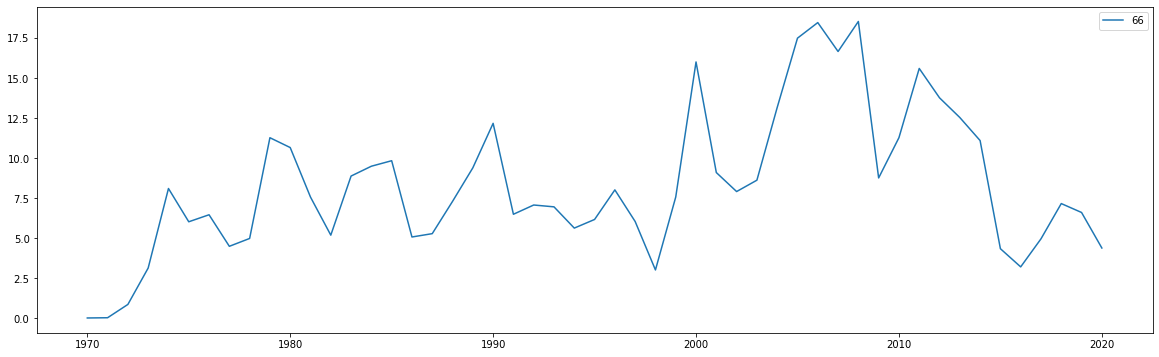

In [75]:
rents_ecu.iloc[14:-2].plot(figsize=(20,6))

In [94]:
data_wti.Date.describe()

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_13212\1887816428.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data_wti.Date.describe()


count                    9232
unique                   9232
top       1986-01-02 00:00:00
freq                        1
first     1986-01-02 00:00:00
last      2022-08-22 00:00:00
Name: Date, dtype: object

In [101]:
data_wti.set_index('Date', inplace=True)

In [102]:
data_wti.head(3)

,Price
Date,
1986-01-02,25.56
1986-01-03,26.00
1986-01-06,26.53


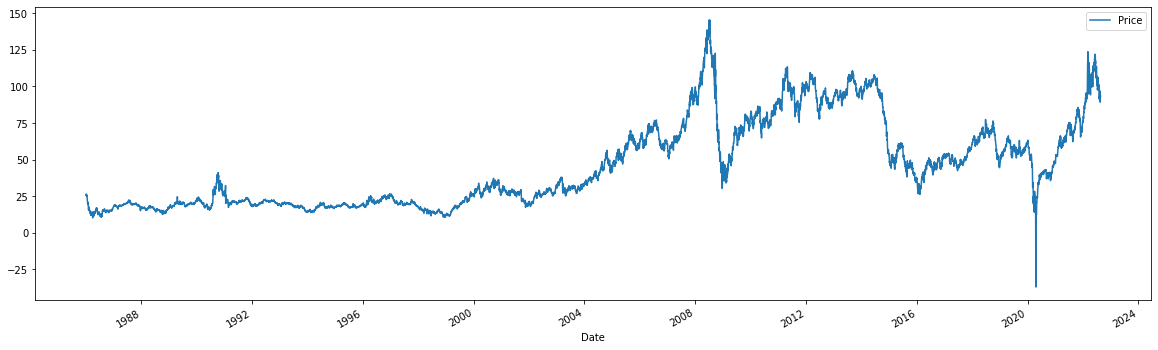

In [103]:
data_wti.plot(figsize=(20,6));

In [80]:
data_wti.describe()

,Price
count,9232.000000
mean,45.661145
std,29.492842
min,-36.980000
25%,19.940000
50%,34.910000
75%,66.035000
max,145.310000


### Normal Distribution

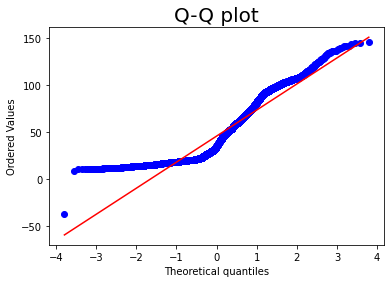

In [81]:
scipy.stats.probplot(data_wti.Price, plot=pylab)
plt.title('Q-Q plot', size=20)
pylab.show() 

In [82]:
data_wti.describe()

,Price
count,9232.000000
mean,45.661145
std,29.492842
min,-36.980000
25%,19.940000
50%,34.910000
75%,66.035000
max,145.310000


### Stationarity

In [84]:
# Determine p-value to determine if data is stationary
sts.adfuller(data_wti)

(-2.213377714641542,
 0.2014259950861617,
 38,
 9193,
 {'1%': -3.4310615334378807,
  '5%': -2.861854452413968,
  '10%': -2.5669373779569864},
 32747.08402618017)

### Seasonality

In [151]:
price_wti = data_wti.asfreq('B')
price_wti.isnull().sum()

Price    326
dtype: int64

In [152]:
price_wti = price_wti.fillna(value=price_wti.mean())
price_wti.isnull().sum()

Price    0
dtype: int64

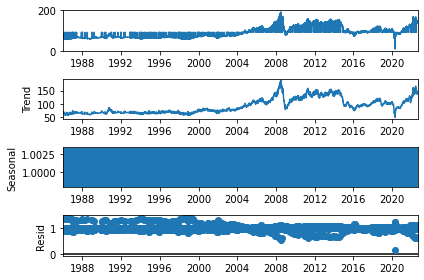

In [157]:
s_dec_multiplicative = seasonal_decompose((price_wti + price_wti.mean()), model = "multiplicative")
s_dec_multiplicative.plot()
plt.show()

### ACF

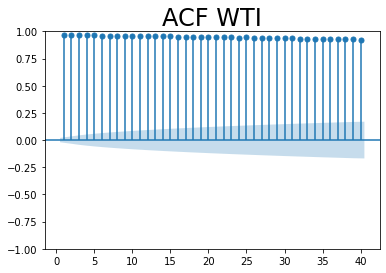

In [160]:
sgt.plot_acf(price_wti, lags=40, zero=False)
plt.title("ACF WTI", size = 24)
plt.show()

### PACF

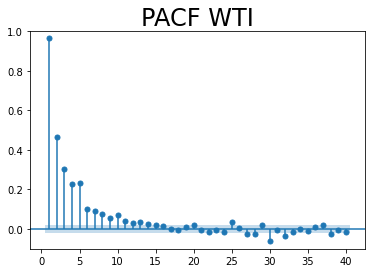

In [164]:
sgt.plot_pacf(price_wti, lags = 40, zero = False, method = ('ols'))
plt.title("PACF WTI", size = 24)
plt.ylim(-0.1,1)
plt.show()